## Video Games Recommendation System

The aim of the project is to offer recommendations for video games based on a particular game title and platform <em>(optional)</em> as the input. This initiative will benefit individuals who are interested in exploring and finding new games.

### Importing and Transforming Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

The dataset was obtained from <a href="https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings">Video Game Sales with Ratings</a> in Kaggle, which were web scraped by Gregory Smith from VGChartz Video Games Sales. The collection of data includes details such as the game's title, genre, the platform it runs on, the company that published it, and other relevant information. From year 1980 up to 2020, the dataset includes a wide range of video game releases that spans over four decades.

In [2]:
video_games_df = pd.read_csv('../notebook/data/steam_games_final_combined.csv')

print(f"No. of records: {video_games_df.shape[0]}")
video_games_df.head(5)

video_games_genres_df = pd.read_csv('../notebook/data/genres.csv')

print(f"No. of records: {video_games_genres_df.shape[0]}")
video_games_genres_df.head(5)

video_games_tags_df = pd.read_csv('../notebook/data/tags.csv')

print(f"No. of records: {video_games_tags_df.shape[0]}")
video_games_tags_df.head(5)

No. of records: 73251
No. of records: 29
No. of records: 417


,Tags
0,Design & Illustration
1,BMX
2,Third-Person Shooter
3,Strategy RPG
4,Transportation


In [3]:
video_games_filtered_df = video_games_df[['name',  'genre', 'mainGenre' , 'tags' , 'mainTag', 'positive', 'negative', 'userScore']]
video_games_filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73251 entries, 0 to 73250
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       73238 non-null  object 
 1   genre      72915 non-null  object 
 2   mainGenre  72915 non-null  object 
 3   tags       73251 non-null  object 
 4   mainTag    73251 non-null  object 
 5   positive   73251 non-null  int64  
 6   negative   73251 non-null  int64  
 7   userScore  73251 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 4.5+ MB


We selected only the features that are relevant for our recommendation system.

In [4]:

i = 0

for genres in video_games_filtered_df['genre']: 


    if (isinstance(genres,str)):
        splitGenres = genres.split(",")
        video_games_filtered_df['genre'][i] = splitGenres
    else:
        if(isinstance(genres,list)):
            temp = [None]*len(genres)
            j = 0
            for genre in genres:
                if(isinstance(genre,list)):
                    temp[j] = genre[0]
                else:
                    temp[j] = genre
                j += 1
            video_games_filtered_df['genre'][i] = temp        
                    
    i += 1
print(video_games_filtered_df['genre'])


0                       [Action,  Strategy,  Free to Play]
1                                  [Action,  Free to Play]
2        [Action,  Adventure,  Massively Multiplayer,  ...
3                                  [Action,  Free to Play]
4        [Action,  Adventure,  Massively Multiplayer,  ...
                               ...                        
73246    [Adventure,  Casual,  Indie,  Racing,  Simulat...
73247    [Adventure,  Indie,  RPG,  Simulation,  Strategy]
73248                          [Casual,  Indie,  Strategy]
73249                                     [Casual,  Indie]
73250                                          [Adventure]
Name: genre, Length: 73251, dtype: object


In [5]:
i = 0

for tags in video_games_filtered_df['tags']: 
    if ( isinstance(tags,str)):
        tags = tags.replace("{" ,"")
        tags = tags.replace("}" ,"")

        tags = tags.replace("'" ,"")
        tags = tags.strip()
        tags = tags.split(",")
        j = 0
        for tag in tags:
            tags[j] =  tag.split(":")[0]
            j += 1
        video_games_filtered_df['tags'][i] = tags      
    i += 1
print(video_games_filtered_df['tags'])



0        [Free to Play,  MOBA,  Multiplayer,  Strategy,...
1        [FPS,  Shooter,  Multiplayer,  Competitive,  A...
2        [Survival,  Shooter,  Battle Royale,  Multipla...
3        [Free to Play,  Hero Shooter,  Multiplayer,  F...
4        [Open World,  Massively Multiplayer,  MMORPG, ...
                               ...                        
73246    [Racing,  Sports,  Driving,  Survival,  Relaxi...
73247    [Pirates,  Sandbox,  Simulation,  RPG,  Typing...
73248    [Strategy,  Indie,  Casual,  Logic,  Puzzle,  ...
73249    [Indie,  Casual,  Typing,  Arcade,  Difficult,...
73250    [Adventure,  Dark,  Puzzle,  Survival Horror, ...
Name: tags, Length: 73251, dtype: object


### Exploratory Data Analysis

Check the total number of missing values for each feature in the dataset 

In [6]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

genre        336
mainGenre    336
name          13
tags           0
mainTag        0
positive       0
negative       0
userScore      0
dtype: int64

Remove the records with missing data in the `Name`, `Genre` and `Ratings` features.

In [7]:
# Remove missing values
video_games_filtered_df.dropna(subset=['name',  'genre', 'mainGenre' ,   'tags' , 'positive', 'negative','userScore'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)

video_games_filtered_df[['name',  'genre',  'mainGenre' , 'tags' , 'positive', 'negative','userScore']].isna().sum()

name         0
genre        0
mainGenre    0
tags         0
positive     0
negative     0
userScore    0
dtype: int64

In [8]:
features = video_games_filtered_df[['mainGenre', 'mainTag']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (400,50))
    sns.countplot(data=video_games_filtered_df, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
plt.show()

Examine the frequency of data types for each categorical feature: `Genre`, `Platform`, and `Rating`.

From the charts above, we can say that there is a scarcity of data available for certain platforms such as DC, and certain ratings such as 'K-A', 'AO’, 'EC' and 'RP'. 

Create additional features that correspond to `User_Score` and `Critic_score` variables. Replace all missing and 'tbd' values with a specific value -- the imputed data is calculated as the mean value of the respective feature within a particular genre, e.g. the average of all scores under the 'Action' category.

Compare the summary statistics of `User_Score` and `Critic_Score` and the new feature with imputed values, i.e.`User_Score_Imputed` and `Critic_Score_Imputed`. The results below show that filling in missing values has no significant impact on the average and the standard deviation.

In [9]:
video_games_filtered_df['userScore'].describe()

count    7.290700e+04
mean     2.308299e+04
std      5.085904e+05
min      0.000000e+00
25%      1.600000e+01
50%      9.750000e+01
75%      6.760000e+02
max      5.497155e+07
Name: userScore, dtype: float64

Drop all the fields related to critic and user scores except for the new features with imputed values.

In [10]:
video_games_final_df = video_games_filtered_df

Analyze the data distribution for `Critic_Score` and `User_Score`, and assess the correlation between these two features.

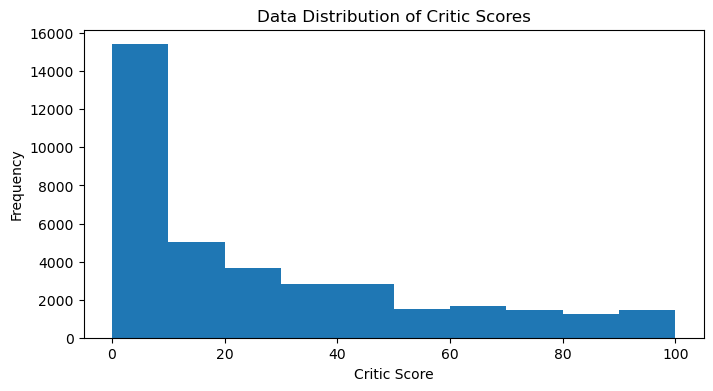

In [11]:
hist, bins = np.histogram(video_games_final_df['userScore'], bins=10, range=(0, 100))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of Critic Scores")
plt.show()

Display the dataframe information to quickly understand its structure and characteristics.

In [12]:
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72907 entries, 0 to 72906
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       72907 non-null  object 
 1   genre      72907 non-null  object 
 2   mainGenre  72907 non-null  object 
 3   tags       72907 non-null  object 
 4   mainTag    72907 non-null  object 
 5   positive   72907 non-null  int64  
 6   negative   72907 non-null  int64  
 7   userScore  72907 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 4.5+ MB


### Converting Categorical Features to Dummy Indicators

Obtain all categorical features, except for the title of the game.

In [13]:
genres_columns = [name for name in video_games_genres_df if name=='Genres' ]
tags_columns = [name for name in video_games_tags_df if name=='Tags' ]

print(f'There are {len(genres_columns)} genres:\n')
print(", ".join(genres_columns))
print(f'There are {len(tags_columns)} tags:\n')
print(", ".join(tags_columns))

There are 1 genres:

Genres
There are 1 tags:

Tags


Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [14]:
genres_games_df_dummy = pd.get_dummies(data=video_games_genres_df, columns=genres_columns)
tags_games_df_dummy = pd.get_dummies(data=video_games_tags_df, columns=tags_columns)


empty = [False] * len(video_games_final_df)

video_games_df_dummy = video_games_final_df
for name in genres_games_df_dummy.columns:
    video_games_df_dummy[name] = empty

for name in tags_games_df_dummy.columns:
    video_games_df_dummy[name] = empty
    
video_games_df_dummy.head(5)    

,name,genre,mainGenre,tags,mainTag,positive,negative,userScore,Genres_Accounting,Genres_Action,...,Tags_Werewolves,Tags_Western,Tags_Wholesome,Tags_Word Game,Tags_World War I,Tags_World War II,Tags_Wrestling,Tags_Zombies,Tags_[],Tags_e-sports
0,Dota 2,"[Action, Strategy, Free to Play]",Action,"[Free to Play, MOBA, Multiplayer, Strategy,...",FreetoPlay,1841595,410305,1.010733e+07,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Counter-Strike: Global Offensive,"[Action, Free to Play]",Action,"[FPS, Shooter, Multiplayer, Competitive, A...",FPS,7042784,1034886,5.497155e+07,False,False,...,False,False,False,False,False,False,False,False,False,False
2,PUBG: BATTLEGROUNDS,"[Action, Adventure, Massively Multiplayer, ...",Action,"[Survival, Shooter, Battle Royale, Multipla...",Survival,1384764,983242,3.335018e+06,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Team Fortress 2,"[Action, Free to Play]",Action,"[Free to Play, Hero Shooter, Multiplayer, F...",FreetoPlay,956242,125664,8.232779e+06,False,False,...,False,False,False,False,False,False,False,False,False,False
4,New World,"[Action, Adventure, Massively Multiplayer, ...",Action,"[Open World, Massively Multiplayer, MMORPG, ...",OpenWorld,193040,81572,6.498688e+05,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:

i = 0
for genres in video_games_df_dummy['genre']:
    for genre in genres: 
        genre = genre.strip()
        if "Genres_"+genre in video_games_df_dummy:
            video_games_df_dummy["Genres_"+genre][i] = True
        else:
            print("Genres_"+genre)
    i += 1   
#         
#i = 0
#for tags in video_games_df_dummy['tags']:
#    for tag in tags: 
#        tag = tag.strip()
#        if "Tags_"+tag in video_games_df_dummy:
#            video_games_df_dummy["Tags_"+tag][i] = True
#        else:
#            print("Tags_"+tag)
#    i += 1       
#*/
video_games_df_dummy.head(5)    


,name,genre,mainGenre,tags,mainTag,positive,negative,userScore,Genres_Accounting,Genres_Action,...,Tags_Werewolves,Tags_Western,Tags_Wholesome,Tags_Word Game,Tags_World War I,Tags_World War II,Tags_Wrestling,Tags_Zombies,Tags_[],Tags_e-sports
0,Dota 2,"[Action, Strategy, Free to Play]",Action,"[Free to Play, MOBA, Multiplayer, Strategy,...",FreetoPlay,1841595,410305,1.010733e+07,False,True,...,False,False,False,False,False,False,False,False,False,False
1,Counter-Strike: Global Offensive,"[Action, Free to Play]",Action,"[FPS, Shooter, Multiplayer, Competitive, A...",FPS,7042784,1034886,5.497155e+07,False,True,...,False,False,False,False,False,False,False,False,False,False
2,PUBG: BATTLEGROUNDS,"[Action, Adventure, Massively Multiplayer, ...",Action,"[Survival, Shooter, Battle Royale, Multipla...",Survival,1384764,983242,3.335018e+06,False,True,...,False,False,False,False,False,False,False,False,False,False
3,Team Fortress 2,"[Action, Free to Play]",Action,"[Free to Play, Hero Shooter, Multiplayer, F...",FreetoPlay,956242,125664,8.232779e+06,False,True,...,False,False,False,False,False,False,False,False,False,False
4,New World,"[Action, Adventure, Massively Multiplayer, ...",Action,"[Open World, Massively Multiplayer, MMORPG, ...",OpenWorld,193040,81572,6.498688e+05,False,True,...,False,False,False,False,False,False,False,False,False,False


After the conversion, the variables have expanded from the original 6 columns to a total of 40 columns.

In [16]:
video_games_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72907 entries, 0 to 72906
Columns: 454 entries, name to Tags_e-sports
dtypes: bool(446), float64(1), int64(2), object(5)
memory usage: 35.5+ MB


### Standardizing the Numerical Features

Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable.

In [17]:
features = video_games_df_dummy.drop(columns=['name'], axis=1)
features = features.drop(columns=['genre'], axis=1)
features = features.drop(columns=['tags'], axis=1)
features = features.drop(columns=['mainGenre'], axis=1)
features = features.drop(columns=['mainTag'], axis=1)
features = features.drop(columns=['positive'], axis=1)
features = features.drop(columns=['negative'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,userScore,Genres_Accounting,Genres_Action,Genres_Adventure,Genres_Animation & Modeling,Genres_Audio Production,Genres_Casual,Genres_Design & Illustration,Genres_Early Access,Genres_Education,...,Tags_Werewolves,Tags_Western,Tags_Wholesome,Tags_Word Game,Tags_World War I,Tags_World War II,Tags_Wrestling,Tags_Zombies,Tags_[],Tags_e-sports
0,19.827969,-0.015715,1.150953,-0.813681,-0.075387,-0.05601,-0.822089,-0.083931,-0.345479,-0.072192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108.041434,-0.015715,1.150953,-0.813681,-0.075387,-0.05601,-0.822089,-0.083931,-0.345479,-0.072192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.512032,-0.015715,1.150953,1.228983,-0.075387,-0.05601,-0.822089,-0.083931,-0.345479,-0.072192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.142168,-0.015715,1.150953,-0.813681,-0.075387,-0.05601,-0.822089,-0.083931,-0.345479,-0.072192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.232406,-0.015715,1.150953,1.228983,-0.075387,-0.05601,-0.822089,-0.083931,-0.345479,-0.072192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating a Model

The machine learning algorithm `NearestNeighbors` will be utilized to identify the data points nearest to a given input, with the aid of the `cosine similarity` measurement to determine the similarity or dissimilarity between data points.

In [18]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


As we included `n_neighbors=1` as a parameter for our model, it will generate 11 indices and distances of games that are similar to the user input, including the input itself.

In [19]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[    0     3     1 33157 19853     9 19848 33133    42    48 19889]
 [    1     9    48    15    37 19863    21    38 33125 19853 26495]
 [    2    40    31    14    24 19850    11 19869 52990 17219    10]
 [    3     0     1 33133 19848    42 19853 19889    20    12 19881]
 [    4 26488 29850 18842 18904 19085 52459 47215 50945 62322 62333]] 

[[0.00000000e+00 9.44612167e-03 2.47492915e-02 2.90679872e-02
  3.18017014e-02 3.21119775e-02 3.22865881e-02 3.24625102e-02
  3.30558547e-02 3.34253450e-02 3.45478228e-02]
 [0.00000000e+00 1.04189940e-03 1.50694290e-03 1.59272447e-03
  2.32519087e-03 2.50484682e-03 2.62199490e-03 4.13977573e-03
  4.83769610e-03 5.05955962e-03 5.38274363e-03]
 [3.33066907e-16 6.30132761e-02 1.00846855e-01 1.50885507e-01
  1.57294215e-01 1.85971813e-01 1.86268655e-01 1.86363881e-01
  1.87673668e-01 1.93316223e-01 1.93951120e-01]
 [0.00000000e+00 9.44612167e-03 3.17255245e-02 3.64595778e-02
  3.64651763e-02 3.6

`TfidfVectorizer` is a feature extraction method commonly used in natural language processing and information retrieval tasks. In this case, it is used to suggest a video game title based on the user input (i.e. game that doesn't exist in the records) by evaluating the importance of words in the input relative to the existing records.

In [20]:
game_names = video_games_df_dummy['name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [21]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   38315  38316  38317  38318  38319  38320  38321  38322  38323  38324  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 38325 columns

### Evaluating the Model

The program utilizes the above-mentioned model to provide video game recommendations to users. It will ask user to enter the game's name and, optionally, the platform to filter the results. The list of recommended games will be arranged in ascending order based on the calculated distances. On the other hand, if the game's name is not in the record, the program will suggest a new name of the game that has the closest match to the input.

In [22]:
with open("../notebook/data/profile.json","r") as profile_file:
    user_profile = json.load(profile_file)

    recommendations = []
    total_games = 0
    skipped_games = 0


In [23]:
def VideoGameTitleRecommender(video_game_name):
    '''
    This function will recommend a game title that has the closest match to the input
    '''
    query_vector = vectorizer.transform([video_game_name])
    similarity_scores = cosine_similarity(query_vector, game_title_vectors)

    closest_match_index = similarity_scores.argmax()
    closest_match_game_name = game_names[closest_match_index]

    return closest_match_game_name


def VideoGameRecommender(video_game_name, video_game_platform='Any'):
    '''
    This function will provide game recommendations based on various features of the game
    '''
    default_platform = 'Any'

    # User input: Game Title and Platform
    if video_game_platform != default_platform:
        video_game_idx = video_games_final_df.query("name == @video_game_name & Platform == @video_game_platform").index
        
        if video_game_idx.empty:
            video_game_idx = video_games_final_df.query("name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: Recommendations will be based on the title of the game as it is not available on the specified platform.\n")
                video_game_platform = default_platform
    
    # User input: Game Title only
    else:
        video_game_idx = video_games_final_df.query("name == @video_game_name").index  
    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # User input: Game Title only
        if video_game_platform == default_platform:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                # Remove from the list any game that shares the same name as the input
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_games_final_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['name'], keep='first')
            
            # Get the first 10 games in the list
            video_game_list = video_game_list.head(10)

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(10))

        # User input: Game Title and Platform
        else:
            # Remove from the list any game that shares the same name as the input
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = video_games_final_df.iloc[recommended_idx]

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform:{video_game_platform}]")

        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        display(recommended_video_game_list.style)

__TEST CASE #1__

__Input:__ Video Game Title

__Expected Result:__ The program merges recommendations from all platforms of the game, arranges the similiarity distances in ascending order, then displays only the first 10 games that has the smallest calculated distance.

In [24]:
VideoGameRecommender('Grand Theft Auto V')

Top 10 Recommended Video Games for 'Grand Theft Auto V' [platform:Any]


__TEST CASE #2__

__Input:__ Video Game Title and Platform

__Expected Result:__ The platform helps to limit the results and display only recommended games based on the specified game and platform.

NOTE: If a platform has limited data like DC, the program might suggest games from other platforms based on various factors when calculating the features similarity.

In [25]:
VideoGameRecommender('Call of Duty: World at War', 'PC')

UndefinedVariableError: name 'Platform' is not defined

__TEST CASE #3__

__Input:__ Video Game Title and Platform

__Constraint:__ Video game is not available on the specified platform

__Expected Result:__ Since the video game is not available on the specified platform, the recommendation is based solely on the game title and ignores the platform.

In [ ]:
VideoGameRecommender('Call of Duty: World at War', 'XB')

Note: Recommendations will be based on the title of the game as it is not available on the specified platform.

Top 10 Recommended Video Games for 'Call of Duty: World at War' [platform:Any]


Name,Platform,Genre,Rating,Critic_Score,User_Score,Similarity_Distance
Bulletstorm,X360,Shooter,M,84.000000,7.600000,0.000000
Halo: Combat Evolved,PC,Shooter,M,83.000000,7.400000,0.000096
Red Faction: Guerrilla,PC,Shooter,M,82.000000,7.500000,0.000099
Battlefield 3,PS3,Shooter,M,85.000000,7.500000,0.000102
Tom Clancy's Rainbow Six: Vegas,PS3,Shooter,M,86.000000,7.600000,0.000103
Unreal Tournament III,PS3,Shooter,M,86.000000,7.700000,0.000200
Quake 4,PC,Shooter,M,81.000000,7.600000,0.000427
Max Payne 3,PS3,Shooter,M,87.000000,7.800000,0.000441
Resistance 3,PS3,Shooter,M,83.000000,7.800000,0.000486
Tom Clancy's Rainbow Six: Vegas 2,X360,Shooter,M,82.000000,7.800000,0.000499


__TEST CASE #4__

__Input:__ Video Game Title

__Constraint:__ Video game is not available in the records

__Expected Result:__ No recommendation is shown but the program provides the user with the game title that has closest match to the input.

In [ ]:
VideoGameRecommender('Call of Duty')

'Call of Duty' doesn't exist in the records.

You may want to try 'Call of Duty 3', which is the closest match to the input.


### Assumptions
- Removed records with missing values in `Name`, `Genre` and `Rating` features
- Conducted data-imputation on missing and 'tbd' values in `User_Score` and `Critic_Score` features. The imputed data was calculated as the mean value of the `User_Score` or `Critic_score` variable within a particular genre, e.g. the average of all scores under the 'Action' category.

### References

1. https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
2. https://thecleverprogrammer.com/2021/01/17/book-recommendation-system/
3. https://aman-makwana101932.medium.com/understanding-recommendation-system-and-knn-with-project-book-recommendation-system-c648e47ff4f6
4. https://www.aurigait.com/blog/recommendation-system-using-knn/
5. https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db

> BDM-3014 Winter 2023 Project (Group 12)